## Setup

In [1]:
import requests
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import architecture
import torch.optim as optim
from architecture import LSTM
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
import math
import matplotlib.animation as animation 
import logging
from IPython.display import HTML
torch.manual_seed(1)
pd.set_option("display.precision", 8)

In [2]:
df = pd.read_csv(f'../xcalibra-market-data/SFX_BTC_minute.csv')
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
hist=df[['close']]['2020-04':]
hist.info()
hist=hist.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
hist['close'] = scaler.fit_transform(hist['close'].values.reshape(-1,1))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69295 entries, 2020-04-01 00:00:00+00:00 to 2020-05-18 15:57:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   69295 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [5]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 2 # choose sequence length
x_train, y_train, x_test, y_test = load_data(hist, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (55434, 1, 1)
y_train.shape =  (55434, 1)
x_test.shape =  (13859, 1, 1)
y_test.shape =  (13859, 1)


In [6]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [7]:
n_steps = look_back-1
batch_size = 256 #1606
#n_iters = 3000
num_epochs = 100 #n_iters / (len(train_X) / batch_size)
#num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [8]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1
lr=0.01

In [9]:
history = np.zeros(num_epochs)
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    x_train = x_train.to(device)
    y_train = y_train.to(device)
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    history[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.13386140763759613
Epoch  20 MSE:  0.03387847915291786
Epoch  30 MSE:  0.00939825177192688
Epoch  40 MSE:  0.0010819978779181838
Epoch  50 MSE:  0.0006888955249451101
Epoch  60 MSE:  0.0006531159160658717
Epoch  70 MSE:  0.0006421365542337298
Epoch  80 MSE:  0.0006379412370733917
Epoch  90 MSE:  0.0006343083805404603


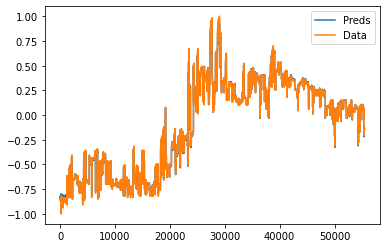

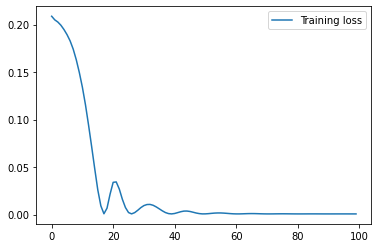

In [10]:
plt.plot(y_train_pred.detach().cpu(), label="Preds")
plt.plot(y_train.detach().cpu(), label="Data")
plt.legend()
plt.show()

plt.plot(history, label="Training loss")
plt.legend()
plt.show()


In [11]:
# make predictions
y_test_pred = model(x_test.to(device))

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

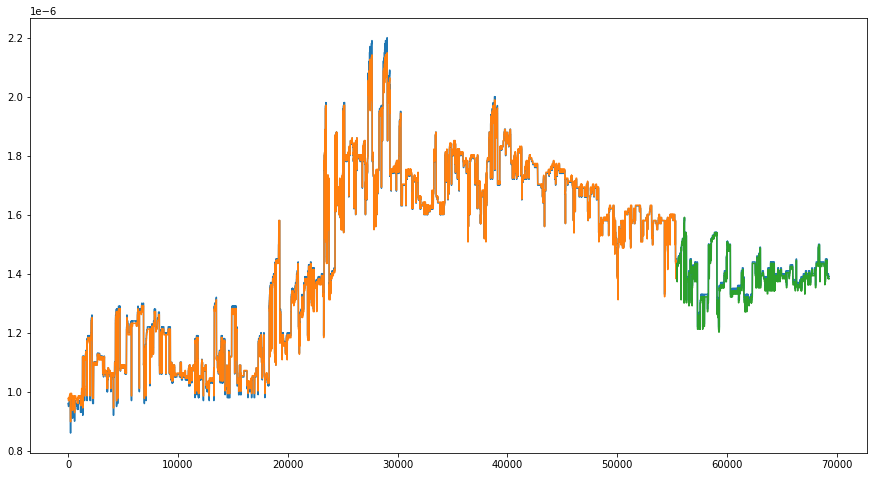

In [12]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(hist)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(hist)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(hist)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(hist))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()